## [Dacon] 블럭 장난감 제조 공정 최적화 경진대회
Original codebase : https://bit.ly/36MNs76

## Library & Data

In [1]:
import pandas as pd
import numpy as np
import multiprocessing
import warnings
from pathlib import Path
from copy import deepcopy
from module.genome import Genome, genome_score
warnings.filterwarnings(action='ignore')
np.random.seed(777)
root_dir = Path().resolve().__str__()

In [2]:
!python --version
print('Pandas : %s'%(pd.__version__))
print('Numpy : %s'%(np.__version__))

Pandas : 1.0.4
Numpy : 1.18.1


Python 3.6.10 :: Anaconda, Inc.


## Data Cleansing & Pre-Processing

In [3]:
# 입력하세요.

## Exploratory Data Analysis

In [4]:
# 입력하세요.

## Feature Engineering & Initial Modeling  

In [5]:
CPU_CORE = multiprocessing.cpu_count() # 멀티프로세싱 CPU 사용 수
N_POPULATION = 50                      # 세대당 생성수
N_BEST = 5                             # 베스트 수
N_CHILDREN = 5                         # 자손 유전자 수
PROB_MUTATION = 0.5                    # 돌연변이
REVERSE = True                         # 배열 순서 (False: ascending order, True: descending order)

score_ini = 0                          # 초기 점수
input_length = 125                     # 입력 데이터 길이
output_length_1 = 18 * 2                # Event (CHECK_1~4, PROCESS) * 2
output_length_2 = 12 * 2               # MOL(0~5.5, step:0.5) * 2
h1 = 50                                # 히든레이어1 노드 수
h2 = 50                                # 히든레이어2 노드 수
h3 = 50                                # 히든레이어3 노드 수
EPOCHS = 15                           # 반복 횟수

genomes = []
for _ in range(N_POPULATION):
    genome = Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3)
    genomes.append(genome)
try:
    for i in range(N_BEST):
        genomes[i] = best_genomes[i]
except:
    best_genomes = []
    for _ in range(5):
        genome = Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3)
        best_genomes.append(genome)

## Model Tuning & Evaluation
1. PRT는 고정값 사용
2. Event A, Event B (MOL_A, MOL_B) 를 같은 값으로 제한
3. Event는 CHECK와 PROCESS 만 사용함
4. 목적 함수로 수요 부족분만 고려함
5. Event와 MOL에 대해 인공신경망 모델을 만들어 유전 알고리즘으로 학습

In [6]:
n_gen = 1
score_history = []
high_score_history = []
mean_score_history = []
while n_gen <= EPOCHS:    
    genomes = np.array(genomes)    
    while len(genomes)%CPU_CORE != 0:
        # Adding more genomes to a generation so that the remainder is 0
        genomes = np.append(genomes, Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3))
    # Reshaping the numpy array
    genomes = genomes.reshape((len(genomes)//CPU_CORE, CPU_CORE))
    
    for idx, _genomes in enumerate(genomes):
        if __name__ == '__main__':
            pool = multiprocessing.Pool(processes=CPU_CORE)
            # mapping Genome.genome_score to genomes
            genomes[idx] = pool.map(genome_score, _genomes)
            pool.close()
            pool.join()
    # genomes object is converted to a list    
    genomes = list(genomes.reshape(genomes.shape[0]*genomes.shape[1]))    
    
     # Sort in ascending order
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    # choose the lowest N_BEST scores and get their average scores
    s = 0
    for i in range(N_BEST):
        s += genomes[i].score
    s /= N_BEST
    
    # Best Score
    bs = genomes[0].score #  ambiguity : genomes is sorted in ascending order
    
    # Add Best Model from previous generation
    if best_genomes is not None:
        genomes.extend(best_genomes)
        
    # Sort in ascending order with best_genomes added.
    genomes.sort(key=lambda x: x.score, reverse=REVERSE)
    
    score_history.append([n_gen, genomes[0].score])
    high_score_history.append([n_gen, bs])  # ambiguity : genomes[0].score = bs
    mean_score_history.append([n_gen, s])
    
    # Print the result
    print('EPOCH #%s\tHistory Best Score: %s\tBest Score: %s\tMean Score: %s' % (n_gen, genomes[0].score, bs, s))    
    
    # Update best_genomes
    best_genomes = deepcopy(genomes[:N_BEST])
    
    # Generate CHILDREN
    for i in range(N_CHILDREN):
        new_genome = deepcopy(best_genomes[0])
        # Randomly choose best_genomes for reproduction
        a_genome = np.random.choice(best_genomes)
        b_genome = np.random.choice(best_genomes)
        
        # ambiguity : new_genome.w1.shape[1] is hidden_layer1 value
        # cut does not do anything
        for j in range(input_length):
            cut = np.random.randint(new_genome.w1.shape[1])
            new_genome.w1[j, :cut] = a_genome.w1[j, :cut]
            new_genome.w1[j, cut:] = b_genome.w1[j, cut:]
        
        for j in range(h1):
            cut = np.random.randint(new_genome.w2.shape[1])
            new_genome.w2[j, :cut] = a_genome.w2[j, :cut]
            new_genome.w2[j, cut:] = b_genome.w2[j, cut:]
        
        for j in range(h2):
            cut = np.random.randint(new_genome.w3.shape[1])
            new_genome.w3[j, :cut] = a_genome.w3[j, :cut]
            new_genome.w3[j, cut:] = b_genome.w3[j, cut:]
        
        for j in range(h3):
            cut = np.random.randint(new_genome.w4.shape[1])
            new_genome.w4[j, :cut] = a_genome.w4[j, :cut]
            new_genome.w4[j, cut:] = b_genome.w4[j, cut:]
            
        for j in range(input_length):
            cut = np.random.randint(new_genome.w5.shape[1])
            new_genome.w5[j, :cut] = a_genome.w5[j, :cut]
            new_genome.w5[j, cut:] = b_genome.w5[j, cut:]
        
        for j in range(h1):
            cut = np.random.randint(new_genome.w6.shape[1])
            new_genome.w6[j, :cut] = a_genome.w6[j, :cut]
            new_genome.w6[j, cut:] = b_genome.w6[j, cut:]
        
        for j in range(h2):
            cut = np.random.randint(new_genome.w7.shape[1])
            new_genome.w7[j, :cut] = a_genome.w7[j, :cut]
            new_genome.w7[j, cut:] = b_genome.w7[j, cut:]
        
        for j in range(h3):
            cut = np.random.randint(new_genome.w8.shape[1])
            new_genome.w8[j, :cut] = a_genome.w8[j, :cut]
            new_genome.w8[j, cut:] = b_genome.w8[j, cut:]
        # best_genomes has N_CHILDREN + N_BEST elements after the loop
        best_genomes.append(new_genome)
    
    # Kill genomes
    genomes = []
    for i in range(int(N_POPULATION / len(best_genomes))):
        for bg in best_genomes:
            new_genome = deepcopy(bg)            
            mean = 0
            stddev = 0.2                        
            # Mutate with 50% chance
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w1 += new_genome.w1 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w2 += new_genome.w2 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w3 += new_genome.w3 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w4 += new_genome.w4 * np.random.normal(mean, stddev, size=(h3, output_length_1)) * np.random.randint(0, 2, (h3, output_length_1))                
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w5 += new_genome.w5 * np.random.normal(mean, stddev, size=(input_length, h1)) * np.random.randint(0, 2, (input_length, h1))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w6 += new_genome.w6 * np.random.normal(mean, stddev, size=(h1, h2)) * np.random.randint(0, 2, (h1, h2))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w7 += new_genome.w7 * np.random.normal(mean, stddev, size=(h2, h3)) * np.random.randint(0, 2, (h2, h3))
            if np.random.uniform(0, 1) < PROB_MUTATION:
                new_genome.w8 += new_genome.w8 * np.random.normal(mean, stddev, size=(h3, output_length_2)) * np.random.randint(0, 2, (h3, output_length_2))
            # Add the mutated genome to genomes
            genomes.append(new_genome)
   
    if REVERSE:
        # why remove half of genomes if previous generation in descending order had lower score than score_ini?
        if bs < score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3) for _ in range(N_POPULATION//2)]
    else:
        # why remove half of genomes if previous generation in ascending order had higher score than score_ini?
        if bs > score_ini:
            genomes[len(genomes)//2:] = [Genome(score_ini, input_length, output_length_1, output_length_2, h1, h2, h3) for _ in range(N_POPULATION//2)]  
        
    n_gen += 1

EPOCH #1	History Best Score: 57.84251652486903	Best Score: 57.84251652486903	Mean Score: 54.78259894502571
EPOCH #2	History Best Score: 82.88498849338097	Best Score: 82.88498849338097	Mean Score: 81.14060003999899
EPOCH #3	History Best Score: 83.4704924574888	Best Score: 83.4704924574888	Mean Score: 82.27098461083787
EPOCH #4	History Best Score: 84.00009830778508	Best Score: 84.00009830778508	Mean Score: 83.09112320638215
EPOCH #5	History Best Score: 84.14861372198496	Best Score: 84.14861372198496	Mean Score: 83.2397766815777
EPOCH #6	History Best Score: 84.26960910059744	Best Score: 84.26960910059744	Mean Score: 83.26585964167427
EPOCH #7	History Best Score: 84.47327979040782	Best Score: 84.47327979040782	Mean Score: 83.91409109998116
EPOCH #8	History Best Score: 84.47327979040782	Best Score: 84.24013519778144	Mean Score: 83.75174021676253
EPOCH #9	History Best Score: 85.37458860496031	Best Score: 85.37458860496031	Mean Score: 84.18282114465285
EPOCH #10	History Best Score: 85.3745886

## Conclusion & Discussion

### 결과 그래프

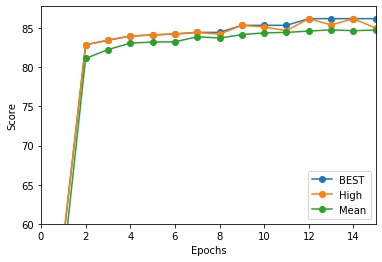

In [7]:
import matplotlib.pyplot as plt

# Score Graph
score_history = np.array(score_history)
high_score_history = np.array(high_score_history)
mean_score_history = np.array(mean_score_history)

plt.plot(score_history[:,0], score_history[:,1], '-o', label='BEST')
plt.plot(high_score_history[:,0], high_score_history[:,1], '-o', label='High')
plt.plot(mean_score_history[:,0], mean_score_history[:,1], '-o', label='Mean')
plt.legend()
plt.xlim(0, EPOCHS)
plt.ylim(bottom=60)
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.show()

### Creating submission.csv

In [8]:
# 재고 계산
from module.simulator import Simulator
simulator = Simulator()
order = pd.read_csv(root_dir + '/data/order.csv')
submission = best_genomes[0].predict(order)
_, df_stock = simulator.get_score(submission) 

# PRT 개수 계산
PRTs = df_stock[['PRT_1', 'PRT_2', 'PRT_3', 'PRT_4']].values
PRTs = (PRTs[:-1] - PRTs[1:])[24*23:]
PRTs = np.ceil(PRTs * 1.1)
PAD = np.zeros((24*23+1, 4))
PRTs = np.append(PRTs, PAD, axis=0).astype(int)

# Submission 파일에 PRT 입력
submission.loc[:, 'PRT_1':'PRT_4'] = PRTs
submission.to_csv(root_dir + '/result/submission.csv', index=False)